<a href="https://colab.research.google.com/github/ngupta23/medium_articles/blob/main/time_series/pycaret/pycaret_ts_multiple_seasonalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def what_is_installed():
    import pycaret
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except:
    !pip install pycaret-ts-alpha
    what_is_installed()


System:
    python: 3.7.12 (default, Jan 15 2022, 18:48:18)  [GCC 7.5.0]
executable: /usr/bin/python3
   machine: Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic

Python dependencies:
          pip: 21.1.3
   setuptools: 57.4.0
      pycaret: 3.0.0
      sklearn: 1.0.2
       sktime: 0.10.1
  statsmodels: 0.12.2
        numpy: 1.21.5
        scipy: 1.7.3
       pandas: 1.3.5
   matplotlib: 3.2.2
       plotly: 5.5.0
       joblib: 1.0.1
        numba: 0.55.1
       mlflow: 1.23.1
     lightgbm: 3.3.2
      xgboost: 0.90
     pmdarima: 1.8.5
        tbats: Installed but version unavailable
      prophet: Not installed
      tsfresh: Not installed


In [2]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


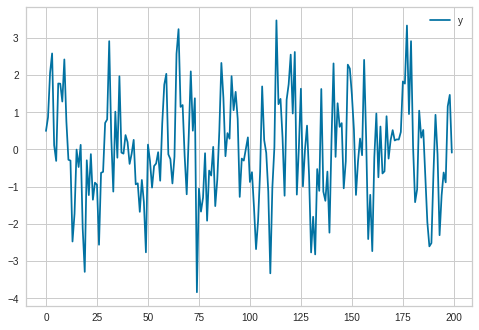

In [10]:
#### Create dataset with multiple seasonalities ----
np.random.seed(42)
sample = 200
x = np.arange(sample)
y = np.sin(2 * np.pi * x / 7) + np.sin(2 * np.pi * x / 28) + np.random.randn(sample)
data = pd.DataFrame(y, columns=["y"])
data.plot()

In [4]:
#### Create Time Series Forecasting Experiment ----
exp = TSForecastingExperiment()
global_plot_settings = {"renderer": "colab"}
exp.setup(data=data, seasonal_period=7, fh=14, fig_kwargs=global_plot_settings, session_id=42)

,Description,Value
0,session_id,42
1,Target,y
2,Original Data,"(200, 1)"
3,Missing Values,False
4,Approach,Univariate
5,Exogenous Variables,Not Present
6,Transformed Train Target,"(186,)"
7,Transformed Test Target,"(14,)"
8,Transformed Train Exogenous,"(186, 0)"
9,Transformed Test Exogenous,"(14, 0)"


In [5]:
#### EDA ----
exp.plot_model()
exp.plot_model(plot="periodogram")

**But Periodogram shows the primary seasonal period of 7, and 28 (peaking).**

Let's model with a single frequency of 7 first and then let's see if this can be improved with multiple seasonal periods.

In [6]:
#### Model with default frequency of 14 (detected during setup) ----
model1 = exp.create_model("tbats")
exp.plot_model(model1)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,143.0,0.8879,1.0185,1.5996,1.1944,0.6609,0.6036,0.1829
1,157.0,0.7999,1.0894,1.1165,0.9745,0.6073,0.6570,0.0021
2,171.0,1.2258,1.5979,2.2349,1.2708,0.9288,0.9570,-0.5657
Mean,NaN,0.9712,1.2353,1.6503,1.1465,0.7324,0.7392,-0.1269
SD,NaN,0.1836,0.2581,0.4580,0.1256,0.1406,0.1555,0.3189


In [7]:
model1

TBATS(box_cox_bounds=(0, 1), context=None, multiprocessing_start_method='spawn',
      n_jobs=None, show_warnings=False, sp=[7], use_arma_errors=True,
      use_box_cox=True, use_damped_trend=None, use_trend=None)

In [8]:
#### Model with multiple seasonal periods ----
# This can be specified using the sp argument (as seen above)
model2 = exp.create_model("tbats", sp=[7, 28])
exp.plot_model(model2)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,143.0,0.7489,0.9639,1.4145,1.2607,0.5575,0.5712,0.2682
1,157.0,0.8768,0.9379,1.8180,1.1610,0.6656,0.5656,0.2603
2,171.0,0.7184,1.0657,0.9830,0.8471,0.5444,0.6382,0.3036
Mean,NaN,0.7814,0.9892,1.4052,1.0896,0.5892,0.5917,0.2773
SD,NaN,0.0686,0.0552,0.3410,0.1763,0.0544,0.0330,0.0188


In [9]:
model2

TBATS(box_cox_bounds=(0, 1), context=None, multiprocessing_start_method='spawn',
      n_jobs=None, show_warnings=False, sp=[7, 28], use_arma_errors=True,
      use_box_cox=True, use_damped_trend=None, use_trend=None)

**Model 1 gives a mean MASE of ~0.73 whereas Model 2 with multiple seasonal periods gives a mean MASE of ~0.59. Hence, we have managed to improve the accuracy of the model by providing multiple seasonal periods appropriately.**